# Нейроинформатика. Лабораторная работа 8
### Динамические сети

Целью работы является исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

Выполнил Лисин Роман, М8О-406Б-20.

In [1]:
!pip install neurolab
!pip install pyrenn
!pip install fireTS

import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.3/645.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neurolab: filename=neurolab-0.3.5-py3-none-any.whl size=22181 sha256=8e45c24e231812f1476c7d5c89ff229764784950c05c8e4e6f782b02908b4808
  Stored in directory: /root/.cache/pip/wheels/1d/c0/44/7142fa43c89473c5e63a750a00224e5f9ec9ca80613de1f97d
Successfully built neurolab
  Preparing metadata (setup.py) ... done
  Created wheel for pyrenn: filename=pyrenn-0.1-py3-none-any.whl size=9239 sha256=c53d0c21cf50c59b7d921c26c473326ecd44457d7e7d20315be5df947ad6c802
  Stored in directory: /root/.cache/pip/wheels/88/73/cf/52f87ad9ea9e987087f5c2b03c8d33e837693325a2e0305736
Successfully built pyrenn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's

##Сеть прямого распространения с запаздыванием для предсказания временного ряда

Число Вольфа - один характерных из показателей солнечной активности. Для заданного момента времени задает количество пятен на Солнце. Для аппроксимации используем среднемесячные значения чисел Вольфа.

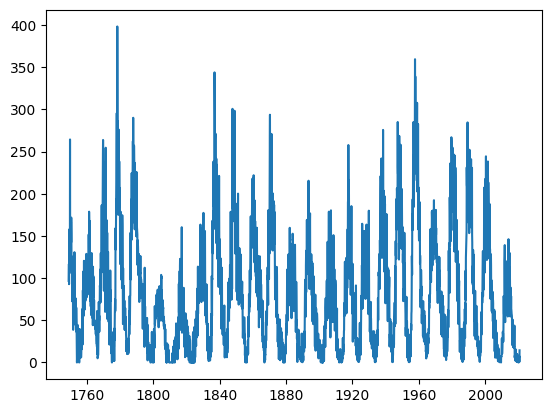

In [22]:
date =  "1879-11-01"
df = pd.read_csv('wolfie.csv', sep=';', header=None)
df = df.iloc[:, 0:4]
df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-'+ df[1])
df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)
df.drop([2], axis=1, inplace=True)
df.head()

plt.plot(df)
plt.show()

Выполняем сглаживание и формируем тестовое множество.

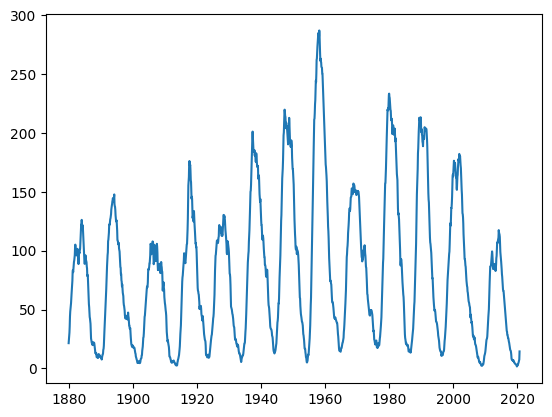

In [23]:
vals = df.values.flatten()
conv = np.convolve(vals, np.ones(12, dtype=int), 'valid') / 12
r = np.arange(1, 11,2)
start = np.cumsum(vals[:(11)-1])[::2] / r
stop = (np.cumsum(vals[:-(11):-1])[::2] / r)[::-1]
smth_values = np.concatenate((start, conv, stop))

shift = df.values.size - smth_values.size
df.iloc[shift:] = smth_values[:, np.newaxis]
df = df[df.index >= pd.to_datetime(date)]
plt.plot(df)
plt.show()

In [29]:
deep = 5
split = int(len(df) * 0.7)
train = df[:split]
test = df[split:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

Опишем сеть.

In [38]:
model = Sequential()
model.add(Dense(8,activation='relu'))
model.add(Dense(8,))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=200)


Epoch 1/200
37/37 [==============================] - 1s 3ms/step - loss: 10367.1729
Epoch 2/200
37/37 [==============================] - 0s 3ms/step - loss: 1987.0604
Epoch 3/200
37/37 [==============================] - 0s 3ms/step - loss: 202.8123
Epoch 4/200
37/37 [==============================] - 0s 3ms/step - loss: 161.5479
Epoch 5/200
37/37 [==============================] - 0s 3ms/step - loss: 157.3987
Epoch 6/200
37/37 [==============================] - 0s 3ms/step - loss: 154.5793
Epoch 7/200
37/37 [==============================] - 0s 3ms/step - loss: 151.4743
Epoch 8/200
37/37 [==============================] - 0s 3ms/step - loss: 148.6340
Epoch 9/200
37/37 [==============================] - 0s 3ms/step - loss: 145.2246
Epoch 10/200
37/37 [==============================] - 0s 3ms/step - loss: 142.0034
Epoch 11/200
37/37 [==============================] - 0s 3ms/step - loss: 137.9074
Epoch 12/200
37/37 [==============================] - 0s 3ms/step - loss: 134.2640
Epoch 13/2

37/37 [==============================] - 0s 2ms/step


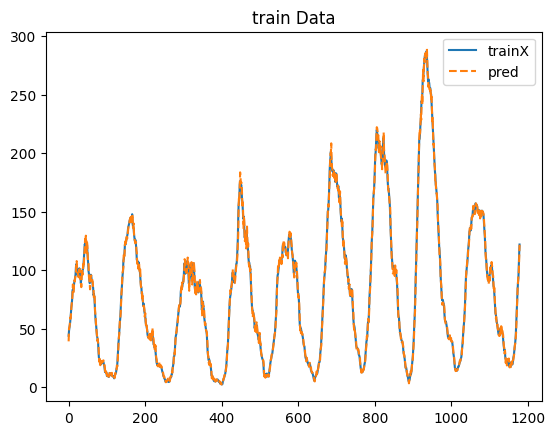

In [39]:
pred = model.predict(xTrain)
plt.plot(yTrain)
plt.plot(pred, '--')

plt.legend(['trainX', 'pred'])
plt.title("train Data")
plt.show()

16/16 [==============================] - 0s 2ms/step


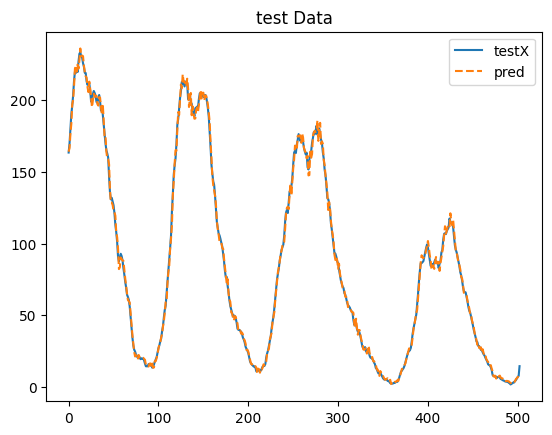

MSE = 7.852698324915448


In [40]:
pred = model.predict(xTest)
plt.plot(yTest)
plt.plot(pred, '--')

plt.legend(['testX', 'pred'])
plt.title("test Data")
plt.show()
MSE = mean_squared_error(yTest, pred)
print('MSE = {}'.format(MSE))

Выполним многошаговый прогноз.

1/1 [==============================] - 0s 29ms/step


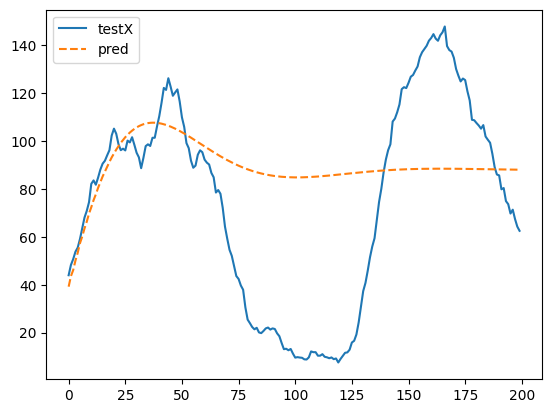

MSE = 1824.252036979638


In [41]:
a = np.array(xTrain[0], ndmin=2)
preds = np.array([])
for i in range(200):
  pred = model.predict(a)
  a = np.append(a[:,1:], pred, axis=1)
  preds = np.append(preds, pred)

plt.plot(yTrain[:200])
plt.plot(preds, '--')

plt.legend(['testX', 'pred'])
plt.show()
MSE = mean_squared_error(yTrain[:len(preds)], preds)
print('MSE = {}'.format(MSE))


##Сеть прямого распространения с распределенным запаздыванием для распознавания динамического образа

Обучающее множество взято из лабораторной работы №5. Входная последовательность
обучающего множества состоит из комбинации основного сигнала p и сигнала, подлежащего распознаванию g. Каждому значению основного сигнала соответствует -1 целевого выхода, каждому значению сигнала g соответствует 1 целевого выхода.

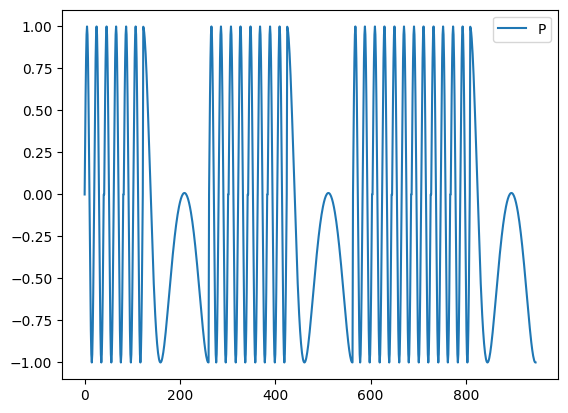

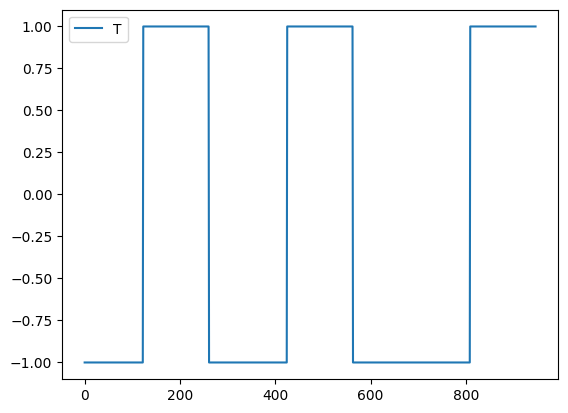

In [9]:
# основа
k1 = np.arange(0, 1+0.025, 0.025)
p = np.sin(4*np.pi*k1)
t1 = np.full(len(p),-1)

# для распознавания
k2 = np.arange(2.84, 6.25+0.025, 0.025)
g = np.sin(k2**2-10*k2+3)
t2 = np.full(len(g), 1)

R = [3,4,6]

P = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(p,1,R[0]), g), np.matlib.repmat(p,1,R[1])),g),np.matlib.repmat(p,1,R[2])),g),ndmin=2).reshape(-1,1)
T = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(t1,1,R[0]), t2), np.matlib.repmat(t1,1,R[1])),t2),np.matlib.repmat(t1,1,R[2])),t2),ndmin=2).reshape(-1,1)

plt.plot(P.reshape(len(P)))
plt.legend(['P'])
plt.show()
plt.plot(T.reshape(len(T)))
plt.legend(['T'])
plt.show()

Опишем сеть.

In [10]:
T = T.ravel()
P = P.ravel()
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])
nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=100)

Maximum number of iterations reached


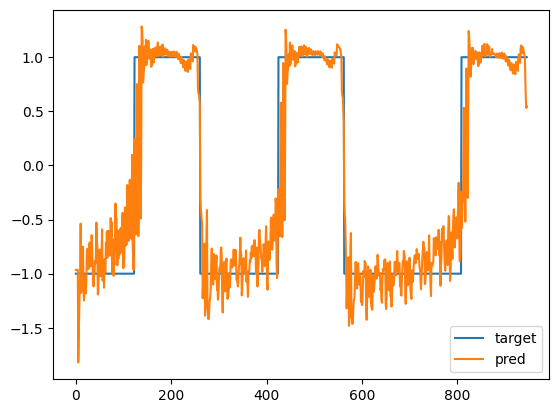

In [11]:
pred = pyrenn.NNOut(P, nn)
plt.plot(T)
plt.plot(pred)
plt.legend(['target', 'pred'])
plt.show()

In [12]:
out = [1 if(i>=0) else -1 for i in pred]
print('final accuracy = {}'.format((out == T.reshape(len(pred))).mean()))

final accuracy = 0.9704329461457233


Проверим качество модели, поменяв длительность основного сигнала R.

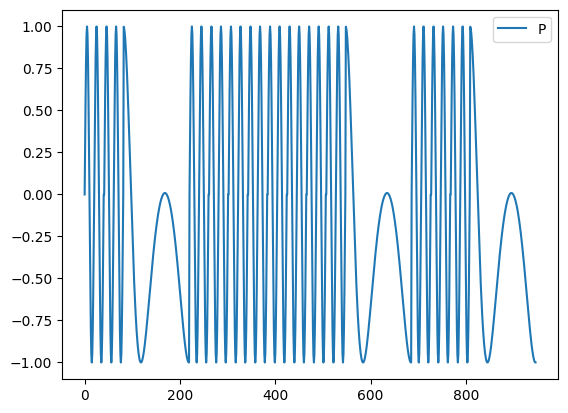

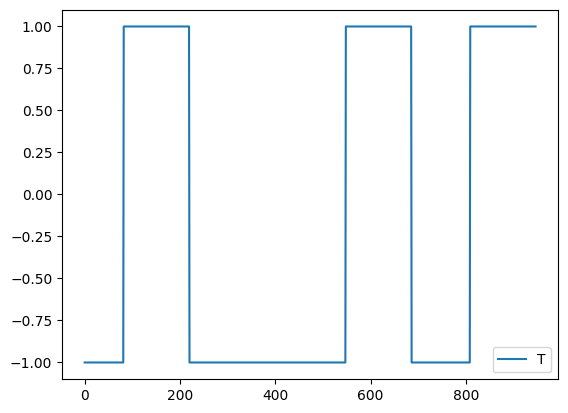

In [13]:
R = [2,8,3]

P = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(p,1,R[0]), g), np.matlib.repmat(p,1,R[1])),g),np.matlib.repmat(p,1,R[2])),g),ndmin=2).reshape(-1,1)
T = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(t1,1,R[0]), t2), np.matlib.repmat(t1,1,R[1])),t2),np.matlib.repmat(t1,1,R[2])),t2),ndmin=2).reshape(-1,1)

plt.plot(P.reshape(len(P)))
plt.legend(['P'])
plt.show()
plt.plot(T.reshape(len(T)))
plt.legend(['T'])
plt.show()

Maximum number of iterations reached


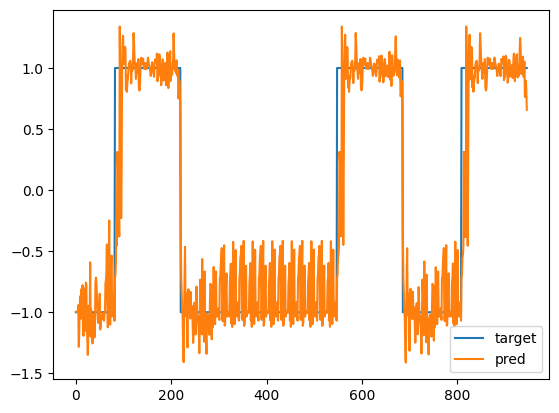

final accuracy = 0.9746568109820486


In [14]:
T = T.ravel()
P = P.ravel()
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])
nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=120)
pred = pyrenn.NNOut(P, nn)
plt.plot(T)
plt.plot(pred)
plt.legend(['target', 'pred'])
plt.show()
out = [1 if(i>=0) else -1 for i in pred]
print('final accuracy = {}'.format((out == T.reshape(len(pred))).mean()))

##Нелинейная авторегрессионная сеть с внешними входами для аппроксимации траектории динамической системы

Определим входной и выходной сигналы.

In [15]:
def u(k):
    return np.cos(k**2 - 15 * k + 3) - np.cos(k)

def y_next(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

k = np.arange(0, 10.01, 0.01)
y = y_next(k)
input = u(k)[:, np.newaxis]
target = y
delay = 3

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]


Опишем сеть NARX.

In [16]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[delay])

narx.fit(input, target)

In [17]:
output = narx.predict(input, target, step=1)
output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))

MSE = 0.20938654125762532


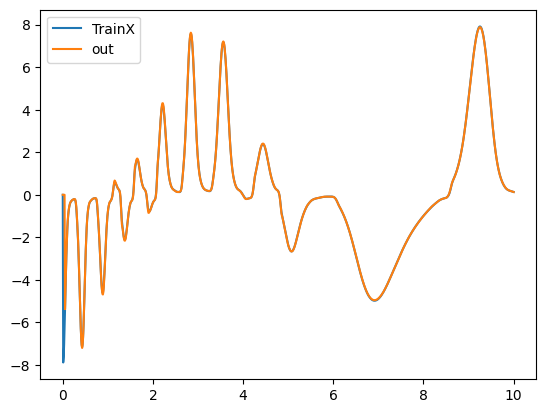

In [18]:
plt.plot(k, y)
plt.plot(k, output)
plt.legend(['TrainX', 'out'])
plt.show()

Выполним многошаговый прогноз.

In [19]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=1000,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(input, target)


MSE = 1.1724809504921836


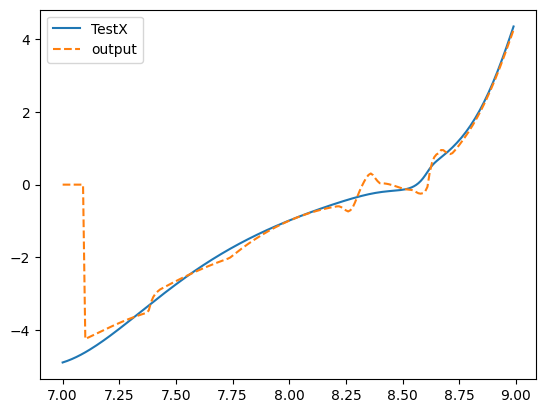

In [20]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
out = narx.predict(inputTest, targetTest, step=5)
out[np.isnan(out)] = 0
MSE = mean_squared_error(targetTest, out)
print('MSE = {}'.format(MSE))
plt.plot(xTest, yTest)
plt.plot(xTest, out, '--')
plt.legend(['TestX', 'output'])
plt.show()

### Вывод

В данной лабораторной работе я изучил и обучил динамические нейронные сети для многошагового прогноза и аппроксимации траектории динамической системы. Сеть NARX прекрасно справляется с многошаговым прогнозом.